**Задание 1. Можно ли отобрать наиболее значимые признаки с помощью PCA?**

**Ответ: Нет, потому что это два разных метода решения задачи понижения размерности данных**

### Курс "Алгоритмы анализа данных". Курсовой проект

**Tutors - expected math exam results. Predict average math exam results for students of the tutors**


https://www.kaggle.com/c/tutors-expected-math-exam-results/rules

#### Ник на Кагле rajulun

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import warnings

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')

title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
label_dict = {'fontsize': '14', 'family': 'Calibri'}


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


### Обзор информации об исходных данных

In [4]:
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [5]:
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,10000,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10003,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
4,10004,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train.shape

(10000, 12)

In [7]:
df_test.shape

(10000, 11)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [10]:
TARGET_NAME = 'mean_exam_points'
BASE_FEATURES = df_train.columns.drop(TARGET_NAME).drop('Id')

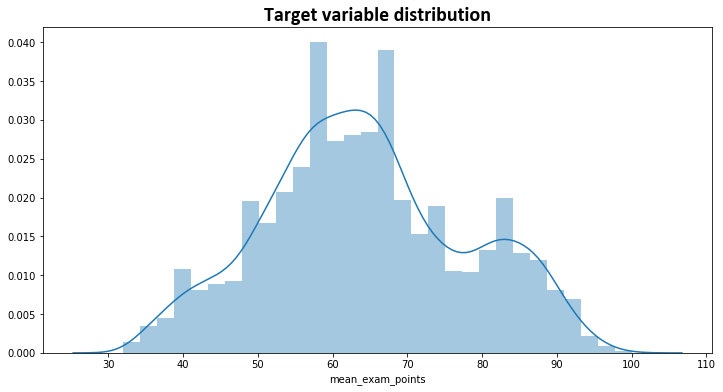

In [11]:
plt.figure(figsize=(12, 6))
sns.distplot(df_train[TARGET_NAME], bins=30)
plt.title('Target variable distribution', fontdict=title_dict);

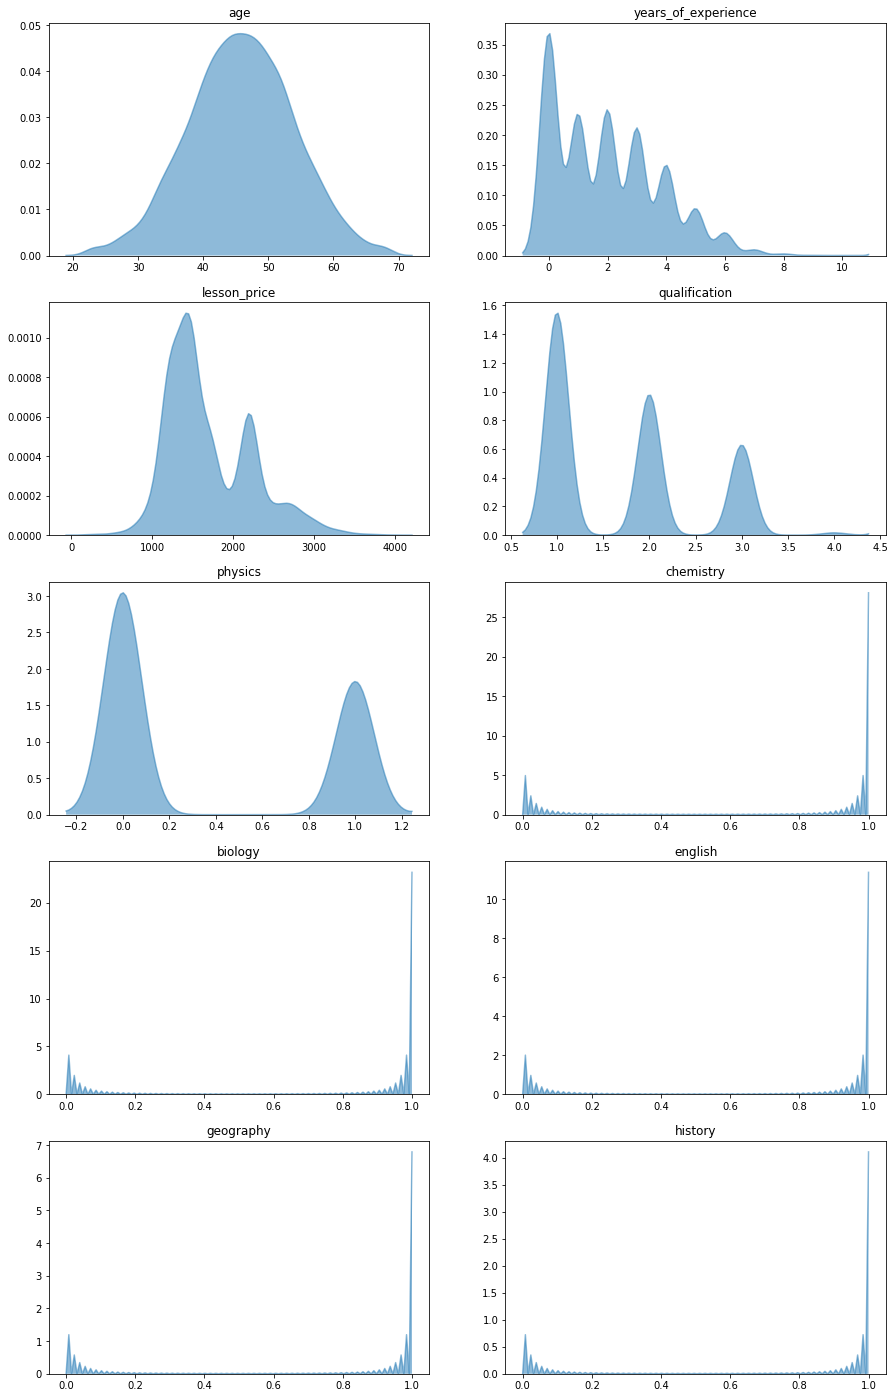

In [12]:
plt.figure(figsize=(15, 30))

for i, colname in enumerate(BASE_FEATURES):
    plt.subplot(6, 2, i+1)
    plt.title(colname)
    sns.kdeplot(df_train[colname], shade=True, alpha=0.5, legend=False)

In [13]:
X = df_train.drop(columns=['Id','mean_exam_points']).values
y = df_train['mean_exam_points'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [14]:
def get_bootstrap(data, labels, N):
    random.seed(5)
    n_samples = int(data.shape[0] * 0.9)
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [15]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(len_sample / 3)
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [16]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [17]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        preds = []
        for label in self.labels:
            preds.append(label)
        preds = np.array(preds)    
        prediction = np.mean(preds)
        return prediction

In [18]:
def dispersion(labels):
    objects = []
        
    for label in labels:
        objects.append(label)
        
    objects = np.array(objects)    
    pred = objects.mean()
    return np.mean((labels - pred) ** 2)

In [19]:
# Расчет качества

def quality(left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)

In [20]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [21]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 3

    current_dispersion = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [22]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    
    return Node(index, t, true_branch, false_branch)

In [23]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [24]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        obj = np.array(obj)
        voted_predictions.append(np.mean(obj))
        
    return voted_predictions

In [30]:
def regression(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return regression(obj, node.true_branch)
    else:
        return regression(obj, node.false_branch)

In [37]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = regression(obj, tree)
        predictions.append(prediction)
    return predictions

In [25]:
def r_2(labels, answers):
    return (1 - np.sum((answers - labels) ** 2) / np.sum((labels - np.mean(labels))**2))

In [26]:
%%time
n_trees = 100
my_forest = random_forest(X_train, y_train, n_trees)

Wall time: 9h 33min 31s


In [31]:
train_answers = tree_vote(my_forest, X_train)
test_answers = tree_vote(my_forest, X_test)

In [55]:
train_r_2 = r_2(y_train, train_answers)
print(train_r_2)

0.8234424653826317


In [56]:
test_r_2 = r_2(y_test, test_answers)
print(test_r_2)

0.7681057984656526


In [57]:
test = np.array(df_test.drop(columns=['Id']))

In [58]:
df_test[TARGET_NAME] = tree_vote(my_forest, test)

In [59]:
df_test.loc[:, ['Id', TARGET_NAME]].to_csv('IIlyasov_predictions_regr.csv', index=False, encoding='utf-8')